# I/O with Pytable

### PytableはHDF5ファイルを扱うために用います

特徴として以下の２つが挙げられます
- 行列を扱うのに長ける
- numpyのような操作感!!
- データの圧縮ができる!!

In [1]:
import tables as tb   #PytablesはLibraryに「tables」で入っています。
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = '/Users/nagaitakahiko/Documents/中嶋ゼミ/'

In [3]:
 filename = path + 'pytab.h5'  #h5ファイルを作る

In [4]:
h5 = tb.open_file(filename, 'w') #wでwriteモードに

In [5]:
row_des = {
              'Date': tb.StringCol(26, pos=1),  
              'No1': tb.IntCol(pos=2),  
              'No2': tb.IntCol(pos=3),  
              'No3': tb.Float64Col(pos=4),  
              'No4': tb.Float64Col(pos=5)  
              }

In [6]:
rows = 2000000

In [7]:
filters = tb.Filters(complevel=5)  #complevelで圧縮率が定義(0~9の間で定義)。Filterは圧縮率を定義可能

In [8]:
tab = h5.create_table('/', 'ints_floats',  
                                row_des,  
                                title='Integers and Floats',  #tableの名前
                                expectedrows=rows,  
                                filters=filters)

In [9]:
 type(tab)

tables.table.Table

In [10]:
tab

/ints_floats (Table(0,), shuffle, zlib(5)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

In [11]:
pointer = tab.row

In [12]:
ran_int = np.random.randint(0, 10000, size=(rows, 2)) #「rowの数」行2列の行列であり0~10000の数

In [13]:
ran_flo = np.random.standard_normal((rows, 2)).round(4)  #正規分布の擬似乱数

In [14]:
%%time
          for i in range(rows):
              pointer['Date'] = dt.datetime.now()  #Dateはここでは操作した時の時間が入る。
              pointer['No1'] = ran_int[i, 0]  #整数値
              pointer['No2'] = ran_int[i, 1]  
              pointer['No3'] = ran_flo[i, 0]  #小数値
              pointer['No4'] = ran_flo[i, 1]  
              pointer.append()  
tab.flush() 

CPU times: user 9.41 s, sys: 82.2 ms, total: 9.49 s
Wall time: 9.67 s


In [15]:
tab  

/ints_floats (Table(2000000,), shuffle, zlib(5)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

In [16]:
tab[:3] 

array([(b'2019-06-20 10:49:08.427556', 4127, 3197, -0.6303,  1.4219),
       (b'2019-06-20 10:49:08.427624', 1955, 9751,  0.6418, -0.3207),
       (b'2019-06-20 10:49:08.427633', 6134, 1279, -1.9172, -1.6238)],
      dtype=[('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'), ('No3', '<f8'), ('No4', '<f8')])

In [17]:
%time np.sum(tab[:]['No3']) #numpy同様の機能(sum)

CPU times: user 455 ms, sys: 47.8 ms, total: 502 ms
Wall time: 503 ms


335.54910000000086

CPU times: user 533 ms, sys: 29.4 ms, total: 562 ms
Wall time: 599 ms


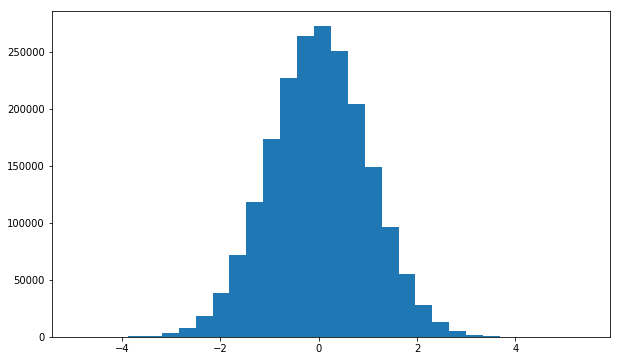

In [18]:
%%time
          plt.figure(figsize=(10, 6))
          plt.hist(tab[:]['No3'], bins=30)

### for文を使っているため上記の処理は比較的遅い
### numpyを用いた処理を行うと速く処理ができる

In [19]:
dty = np.dtype([('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'),
                                           ('No3', '<f8'), ('No4', '<f8')])
#データタイプを規定

In [20]:
 sarray = np.zeros(len(ran_int), dtype=dty)   #0行列

In [21]:
sarray[:4] #一部を取り出す 

array([(b'', 0, 0, 0., 0.), (b'', 0, 0, 0., 0.), (b'', 0, 0, 0., 0.),
       (b'', 0, 0, 0., 0.)],
      dtype=[('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'), ('No3', '<f8'), ('No4', '<f8')])

In [22]:
%%time
          sarray['Date'] = dt.datetime.now()  
          sarray['No1'] = ran_int[:, 0]  
          sarray['No2'] = ran_int[:, 1]  
          sarray['No3'] = ran_flo[:, 0]  
          sarray['No4'] = ran_flo[:, 1]    #In[14]に比べると格段に速い　

CPU times: user 109 ms, sys: 2.2 ms, total: 111 ms
Wall time: 111 ms


In [23]:
filename = path + 'pytabc.h5'
h5c = tb.open_file(filename, 'w')
filters = tb.Filters(complevel=5,  
                               complib='blosc')  
tabc = h5c.create_table('/', 'ints_floats', sarray,
                                  title='Integers and Floats',
                                  expectedrows=rows, filters=filters)

In [46]:
query = '((No3 < -0.5) | (No3 > 0.5)) & ((No4 < -1) | (No4 > 1))'
iterator = tab.where(query)    #iteratorはlistのコピーみたいなもの

In [25]:
%time res = [(row['No3'], row['No4']) for row in iterator]

CPU times: user 660 ms, sys: 50 ms, total: 710 ms
Wall time: 696 ms


In [26]:
res = np.array(res)  
res[:5]

array([[-0.6303,  1.4219],
       [-1.9172, -1.6238],
       [ 1.1965, -1.0728],
       [ 0.7448, -1.4509],
       [-2.2848, -2.0353]])

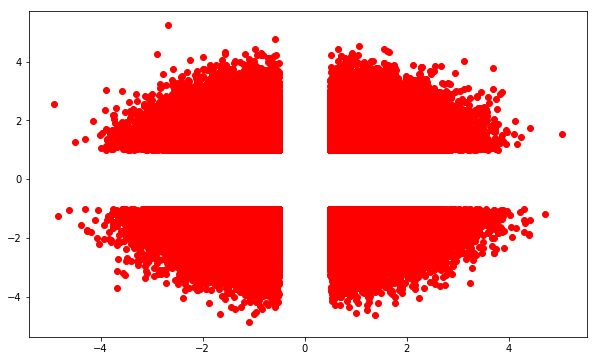

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(res.T[0], res.T[1], 'ro');

In [28]:
filename = path + 'earray.h5'
h5 = tb.open_file(filename, 'w')
n = 500  
ear = h5.create_earray('/', 'ear',  
                                atom=tb.Float64Atom(),  
                                shape=(0, n))

In [29]:
type(ear)

tables.earray.EArray

In [30]:
rand = np.random.standard_normal((n, n))  
rand[:4, :4]

array([[ 0.85432676, -0.86252419,  0.48203994, -0.16257479],
       [ 1.39222371,  0.0418079 ,  0.36807902, -1.4372718 ],
       [ 1.39751399,  0.00231545,  1.78658167,  2.0844786 ],
       [-0.33492329,  0.59982154,  0.98860673, -1.81647399]])

In [31]:
%%time
for _ in range(750):
              ear.append(rand)  
ear.flush()

CPU times: user 581 ms, sys: 816 ms, total: 1.4 s
Wall time: 2.03 s


In [32]:
ear

/ear (EArray(375000, 500)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16, 500)

In [33]:
ear.size_on_disk

1500032000

In [34]:
out = h5.create_earray('/', 'out',
                                atom=tb.Float64Atom(),
                                shape=(0, n))

In [35]:
expr = tb.Expr('3 * sin(ear) + sqrt(abs(ear))')

In [36]:
expr.set_output(out, append_mode=True)

In [37]:
 %time expr.eval() 

CPU times: user 3.27 s, sys: 2.05 s, total: 5.32 s
Wall time: 9.27 s


/out (EArray(375000, 500)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16, 500)

In [38]:
%time out_ = out.read()

CPU times: user 885 ms, sys: 1.58 s, total: 2.46 s
Wall time: 5.23 s


In [39]:
#TsTable
no = 5000000  
co = 3  
interval = 1. / (12 * 30 * 24 * 60) 
vol = 0.2

In [40]:
rn = np.random.standard_normal((no, co))  
rn[0] = 0.0  
paths = 100 * np.exp(np.cumsum(-0.5 * vol ** 2 * interval +vol * np.sqrt(interval) * rn, axis=0))  
paths[0] = 100  

In [41]:
dr = pd.date_range('2019-1-1', periods=no, freq='1s')

In [42]:
dr[-6:]

DatetimeIndex(['2019-02-27 20:53:14', '2019-02-27 20:53:15',
               '2019-02-27 20:53:16', '2019-02-27 20:53:17',
               '2019-02-27 20:53:18', '2019-02-27 20:53:19'],
              dtype='datetime64[ns]', freq='S')

In [43]:
df = pd.DataFrame(paths, index=dr, columns=['ts1', 'ts2', 'ts3'])

In [44]:
df.head()              

,ts1,ts2,ts3
2019-01-01 00:00:00,100.000000,100.000000,100.000000
2019-01-01 00:00:01,100.000851,99.988748,99.969583
2019-01-01 00:00:02,99.964192,100.069826,99.847428
2019-01-01 00:00:03,99.988766,100.031353,99.813762
2019-01-01 00:00:04,99.929796,99.989724,99.825407


In [45]:
import tstables as tstab

ModuleNotFoundError: No module named 'tstables'

## Tstablesはanacondaには入っていないので教科書を見ながら説明します

#### 概説するとTstablesは膨大な時系列データの処理を高速でできます